In [81]:
# % Fig 5: fine-tuning metaparameters of "iterations" 
# % 	- batch size effect on the iterations performance
# % 	- add/noadd & different ranking schemes effect
# % 	- comparison  of the best model with with docking-as-predictor
# % 	- TODO: comparison with the really best single model

# % How did we come up with iterations scheme:
# % 	- compared different train sizes
# % 	- compared different regimes (add/noadd)
# % 	- compared different ensembling methods
# % 	- compare with "docking-as-predictor"


In [18]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm.notebook import tqdm

def retrieve_iteration_size(df: pd.DataFrame) -> dict:
    possible_num_iterations = df.tot_num_of_iterations.unique()
    
    rv = {}
    for n_it in possible_num_iterations:
        subdf = df[df.tot_num_of_iterations == n_it]
        docked_sizes = subdf.docked_size.unique()
        differences = [abs(i-j) for i in docked_sizes for j in docked_sizes if i!=j]
        rv[n_it] = min(differences)
    return rv

def add_iteration_size(df: pd.DataFrame):
    d = retrieve_iteration_size(df)
    df['iteration_size'] = df.apply({'tot_num_of_iterations': lambda x: d.get(x, None)})
    return df

In [49]:
%%time

datasets = {
    'AmpC':'../data/AmpC_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv',
    'D4'  :'../data/D4_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv',
    '4eiy':'../data/4eiy_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv',
    '5zty':'../data/5zty_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv'
           }
dataset_size = {'AmpC':96214206, 'D4':138312677, '4eiy':int(1e6),'5zty':int(1e6)}

dfs = []
for name, path in tqdm(datasets.items()):
    df = pd.read_csv(path)
    df['proj'] = name
    df['N_ligands'] = dataset_size.get(name)
    dfs.append(df)

raw_data = pd.concat(dfs)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 4.79 s, sys: 648 ms, total: 5.43 s
Wall time: 5.42 s


In [50]:
df = (raw_data
      .reset_index()
      .replace({
        'add':'True',
        'noadd':'False'
      })
      .drop(['index','Unnamed: 0'], axis=1)
#       .query("type == 'regressor'")
#       .query("add_to_train == 'False'")
#       .query("prediction_method == 'MeanRank'")
        .pipe(add_iteration_size)
#       .assign(model_and_proj = lambda df: df.proj + '_' + df.model)
#       .assign(tot_num_of_iterations = lambda df: df.tot_num_of_iterations + 1)
#       .query("proj == '4eiy'")
)


In [52]:
df.proj.value_counts()

4eiy    3495
AmpC    2808
D4      1872
5zty    1599
Name: proj, dtype: int64

In [73]:
param_space = \
[
        'proj',
        'model',
        'prediction_method',
        'tot_num_of_iterations',
        'add_to_train'
    ]

In [74]:
(df
 .query('proj=="4eiy"')
)[param_space].value_counts()

proj  model                    prediction_method  tot_num_of_iterations  add_to_train
4eiy  LinearRegression         MeanRank           30                     True            124
                               TopFromEveryModel  30                     True            124
                               LastModel          30                     True            124
                                                                         False           124
      RandomGaussianRegressor  LastModel          30                     False           124
                                                                                        ... 
      DockingAsPredictor       LastModel          3                      True              4
                               TopFromEveryModel  2                      True              3
                                                                         False             3
                               LastModel          2                      True

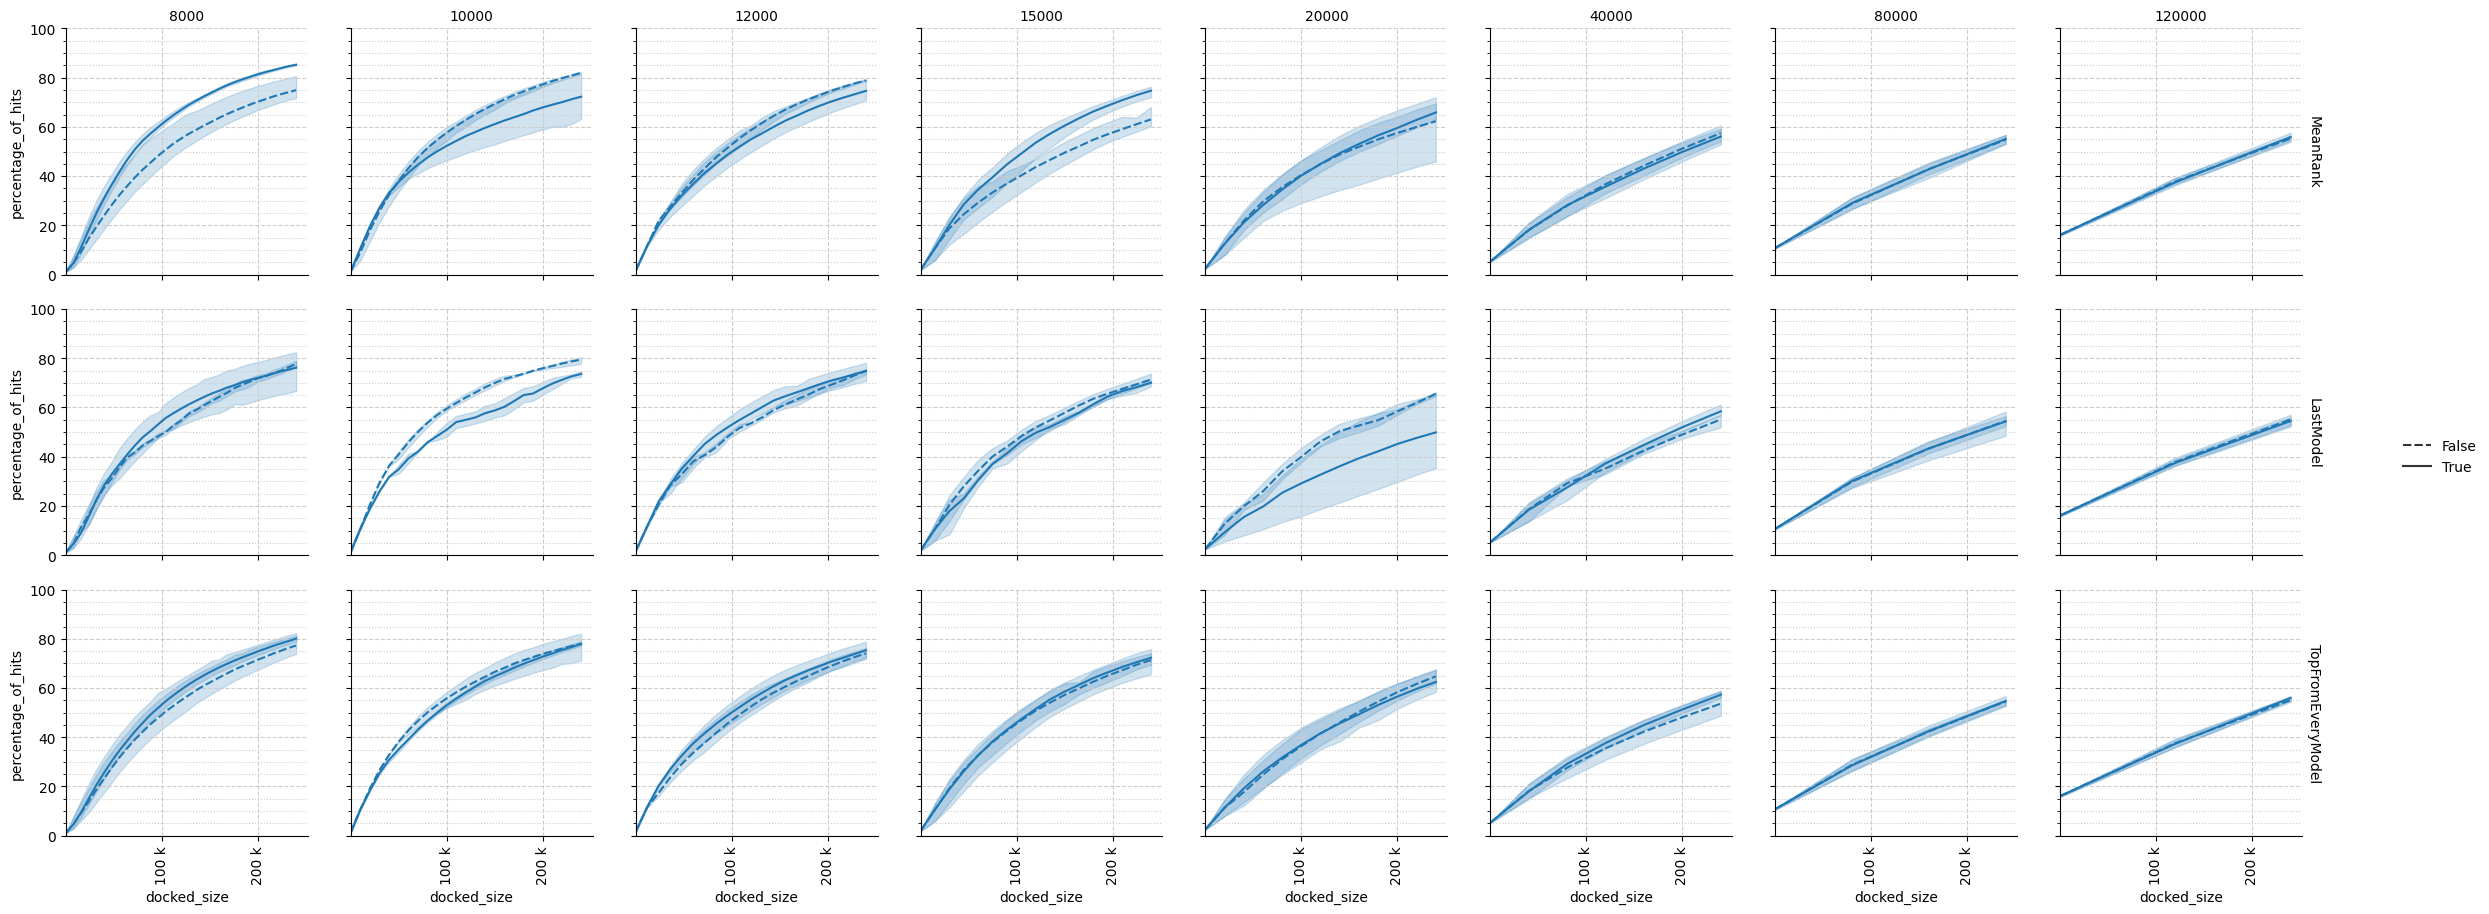

In [115]:
df = (raw_data
      .reset_index()
      .replace({
        'add':'True',
        'noadd':'False'
      })
      .query("model == 'LinearRegression'")
        .pipe(add_iteration_size)
      .assign(model_and_proj = lambda df: df.proj + '_' + df.model)
#       .assign(tot_num_of_iterations = lambda df: df.tot_num_of_iterations + 1)
      .query("proj == '4eiy'")
)

kwa = {
    'x': 'docked_size',
    'y': "percentage_of_hits", 
#     'hue': "iteration_size",
    'style':'add_to_train'
}

grid = sns.FacetGrid(df, 
                     col = "iteration_size", 
                     row = "prediction_method",
                     margin_titles=True,
                     sharex=True,
                     sharey=True
                    )
(grid
 .map_dataframe(sns.lineplot, **kwa, palette='colorblind')
#  .set(xscale = 'log')
)

for ax in grid.axes.flat:
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    
    ax.set_ylim(0, 100)
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')
    
    ax.set_xlim(1,None)
    ax.hlines([25], linestyle='--', xmin=0, xmax=100, linewidth=3, color='k')
    
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.setp(ax.get_xticklabels(), rotation=90)

grid.set_titles(row_template = '{row_name}', col_template = '{col_name}')
grid.add_legend()

# plt.savefig('../figures/Figure_3.png')
plt.show()

# Make sure we know which model is the best for 4eiy

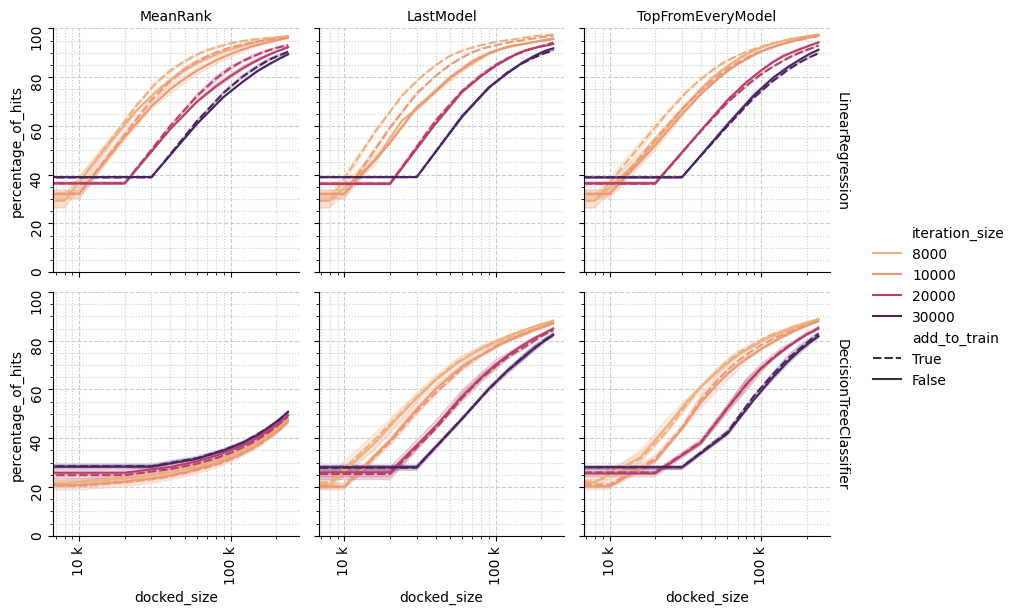

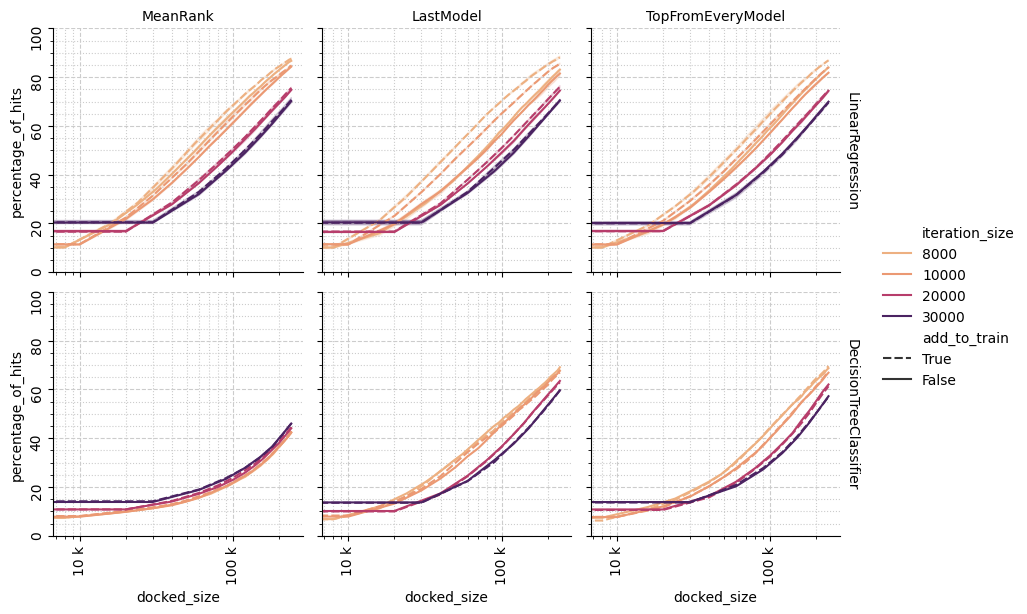

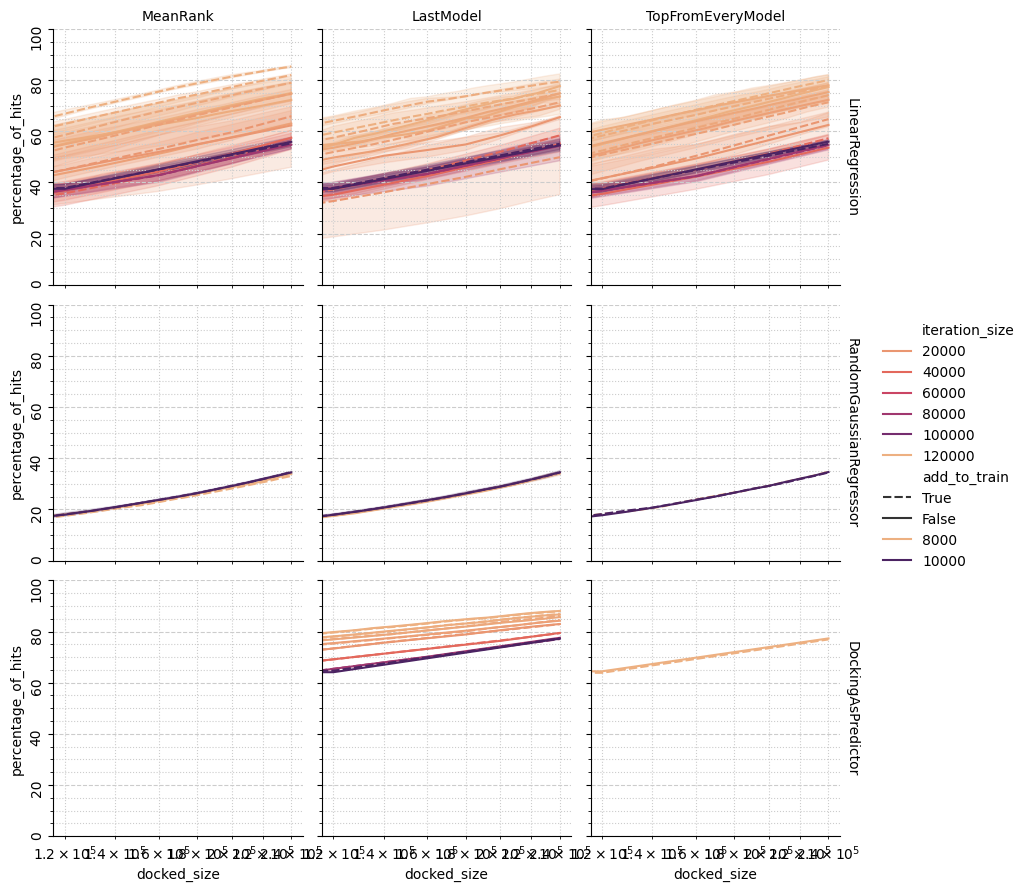

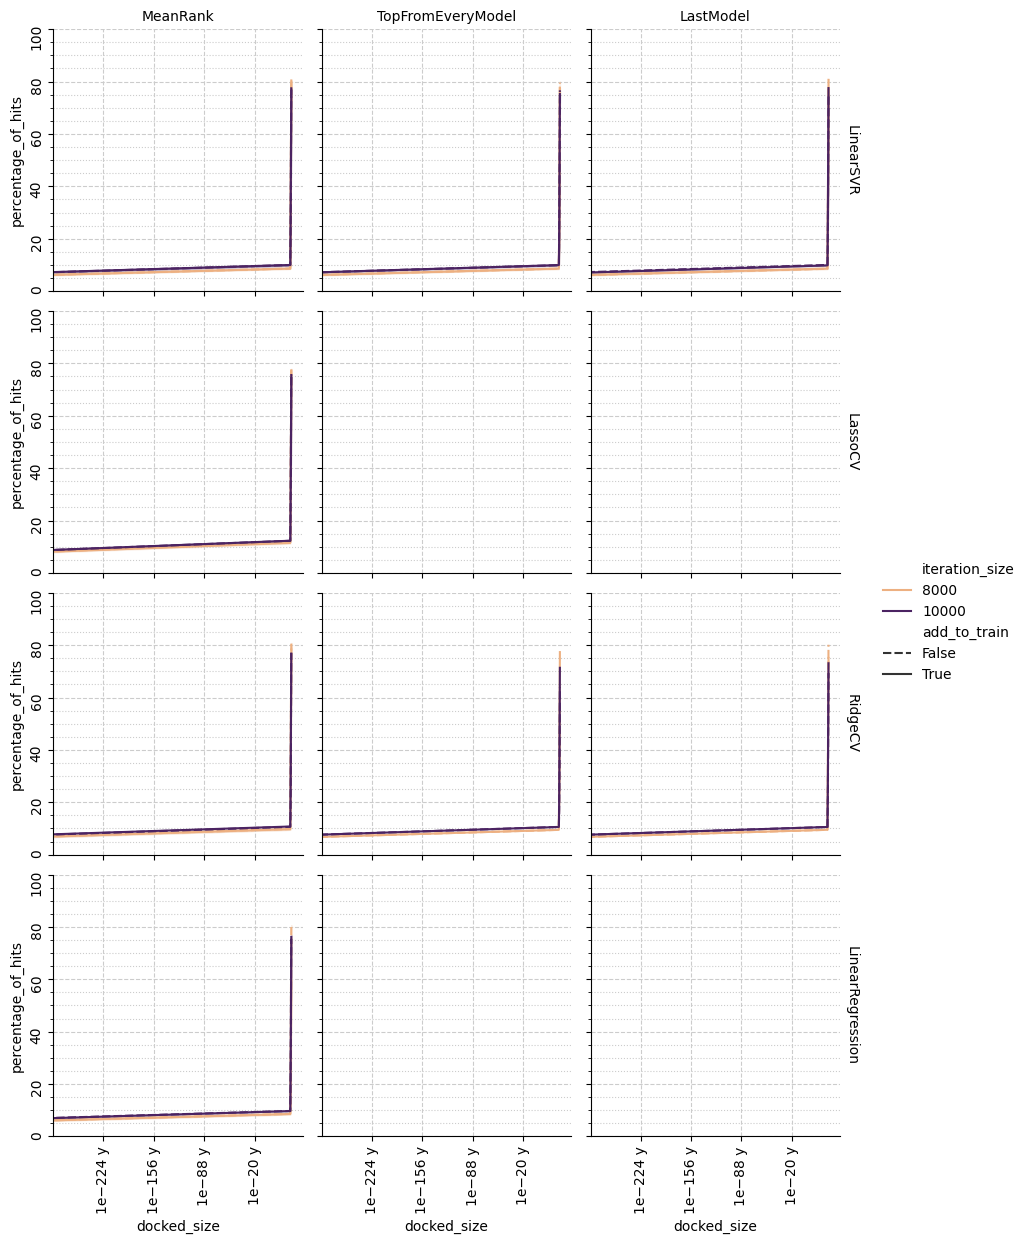

In [84]:
for proj in datasets:
    df = (raw_data
          .reset_index()
          .replace({
            'add':'True',
            'noadd':'False'
          })
    #       .query("type == 'regressor'")
    #       .query("add_to_train == 'False'")
    #       .query("prediction_method == 'MeanRank'")
            .pipe(add_iteration_size)
          .assign(model_and_proj = lambda df: df.proj + '_' + df.model)
    #       .assign(tot_num_of_iterations = lambda df: df.tot_num_of_iterations + 1)
          .query(f"proj == '{proj}'")
    )

    kwa = {
        'x': 'docked_size',
        'y': "percentage_of_hits", 
        'hue': "iteration_size",
        'style':'add_to_train'
    }

    grid = sns.FacetGrid(df, 
                         row = "model", 
                         col = "prediction_method",
                         margin_titles=True
                        )
    (grid
     .map_dataframe(sns.lineplot, **kwa, palette='flare')
     .set(xscale = 'log')
    )

    for ax in grid.axes.flat:
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        ax.yaxis.set_minor_locator(AutoMinorLocator(4))

        ax.set_ylim(0, 100)
        ax.grid(which='major', color='#CCCCCC', linestyle='--')
        ax.grid(which='minor', color='#CCCCCC', linestyle=':')
    #     ax.set_xlim(1,None)
        plt.setp(ax.get_yticklabels(), rotation=90)
        plt.setp(ax.get_xticklabels(), rotation=90)


    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    grid.add_legend()

    plt.savefig(f'../figures/Figure_3_{proj}_models.png')
    plt.show()

# Test the first iteration only

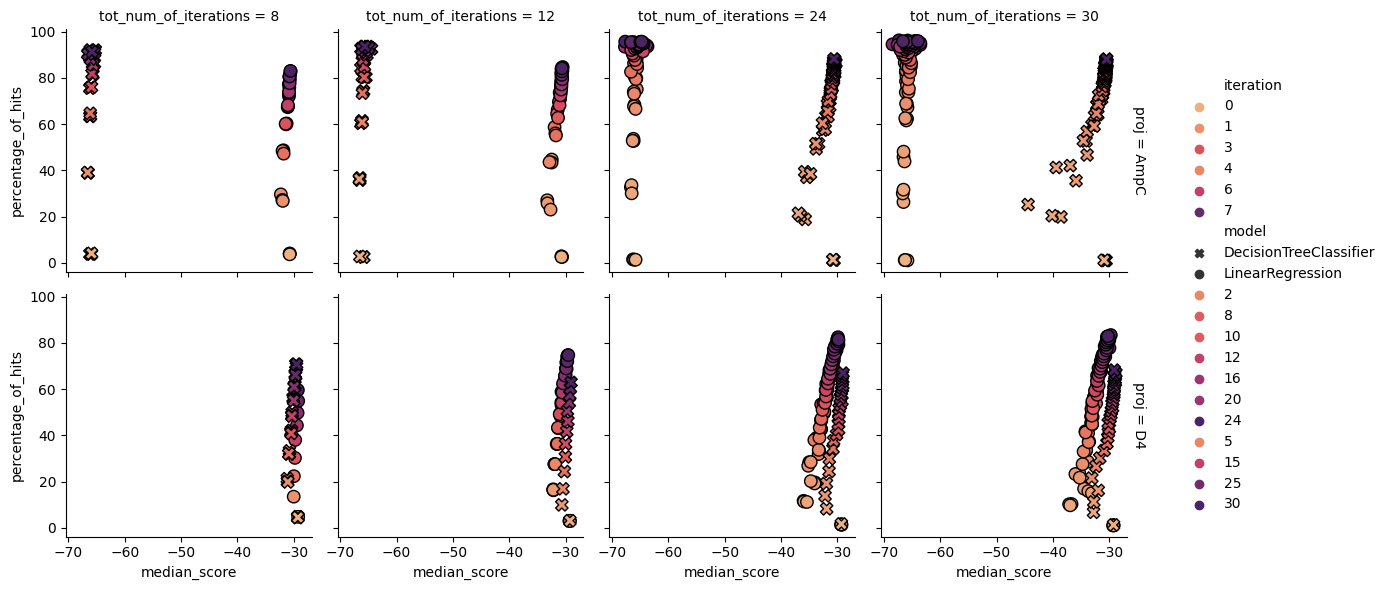

In [164]:
df = (raw_data
      .reset_index()
      .replace({
        'add':'True',
        'noadd':'False'
      })
      .pipe(add_iteration_size)
      .query("add_to_train == 'False'")
      .query("prediction_method == 'LastModel'")
      .assign(model_and_proj = lambda df: df.proj + '_' + df.model)
#       .query('iteration == 1')
#       .query("proj == 'D4'")
)

kwa = {
#     'x' : "log2_time_sec", 
    'x': 'median_score',
    'y': "percentage_of_hits", 
    'style': "model",
    'hue':'iteration',
    'edgecolor':'k',
    'linewidth':1,
    's':80
    
}

grid = sns.FacetGrid(df, col = "tot_num_of_iterations", row = "proj", margin_titles=True)
(grid
 .map_dataframe(sns.scatterplot, **kwa, palette='flare')
#  .set(xscale = 'log')
)

grid.add_legend()
# plt.savefig('../figures/Figure_4.png')
plt.show()

In [100]:
raw_data.prediction_method.unique()

array(['MeanRank', 'LastModel', 'TopFromEveryModel'], dtype=object)

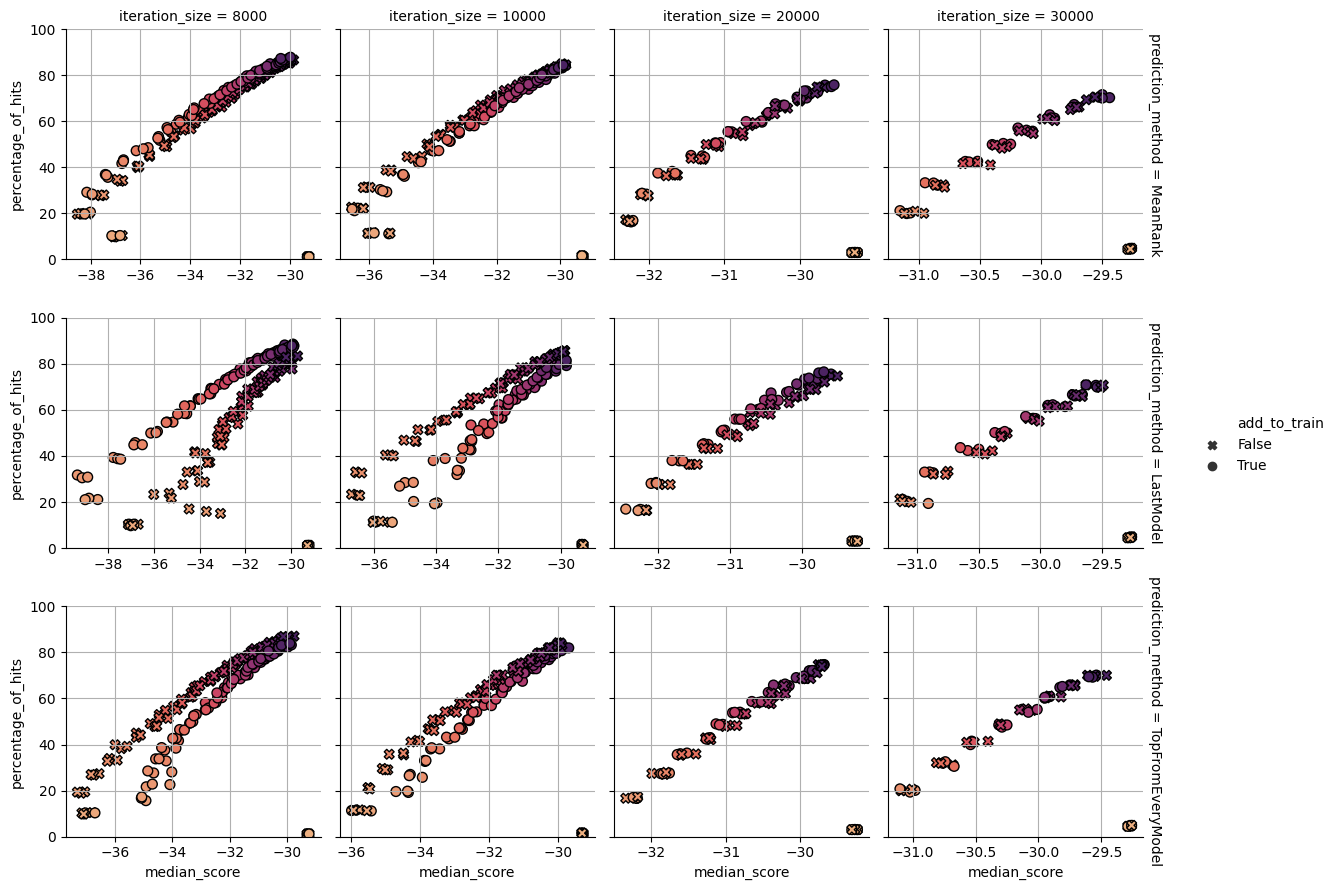

In [25]:
df = (raw_data
      .reset_index()
      .replace({
        'add':'True',
        'noadd':'False'
      })
      .pipe(add_iteration_size)
#       .query("add_to_train == 'False'")
      .query("type == 'regressor'")
#       .query("prediction_method == 'TopFromEveryModel'")
      .assign(model_and_proj = lambda df: df.proj + '_' + df.model)
#       .query('iteration == 1')
      .query("proj == 'D4'")
)

kwa = {
#     'x' : "log2_time_sec", 
    'x': 'median_score',
    'y': "percentage_of_hits", 
    'style': "add_to_train",
    'hue':'iteration',
    'edgecolor':'k',
    'linewidth':1,
    's':50,
#     'legend':False
}

grid = sns.FacetGrid(df, col = "iteration_size", row = "prediction_method", margin_titles=True, sharex=False)

(grid
 .map_dataframe(sns.scatterplot, **kwa, palette='flare')
#  .set(xscale = 'log')
)

for ax in grid.axes.flat:
    ax.grid()
    ax.set_ylim(0, 100)

included_labels = ['True','False','add_to_train']
grid.add_legend(legend_data = {k:v for k, v in grid._legend_data.items() if k in included_labels})
plt.savefig('../figures/Figure_3.png')
plt.show()

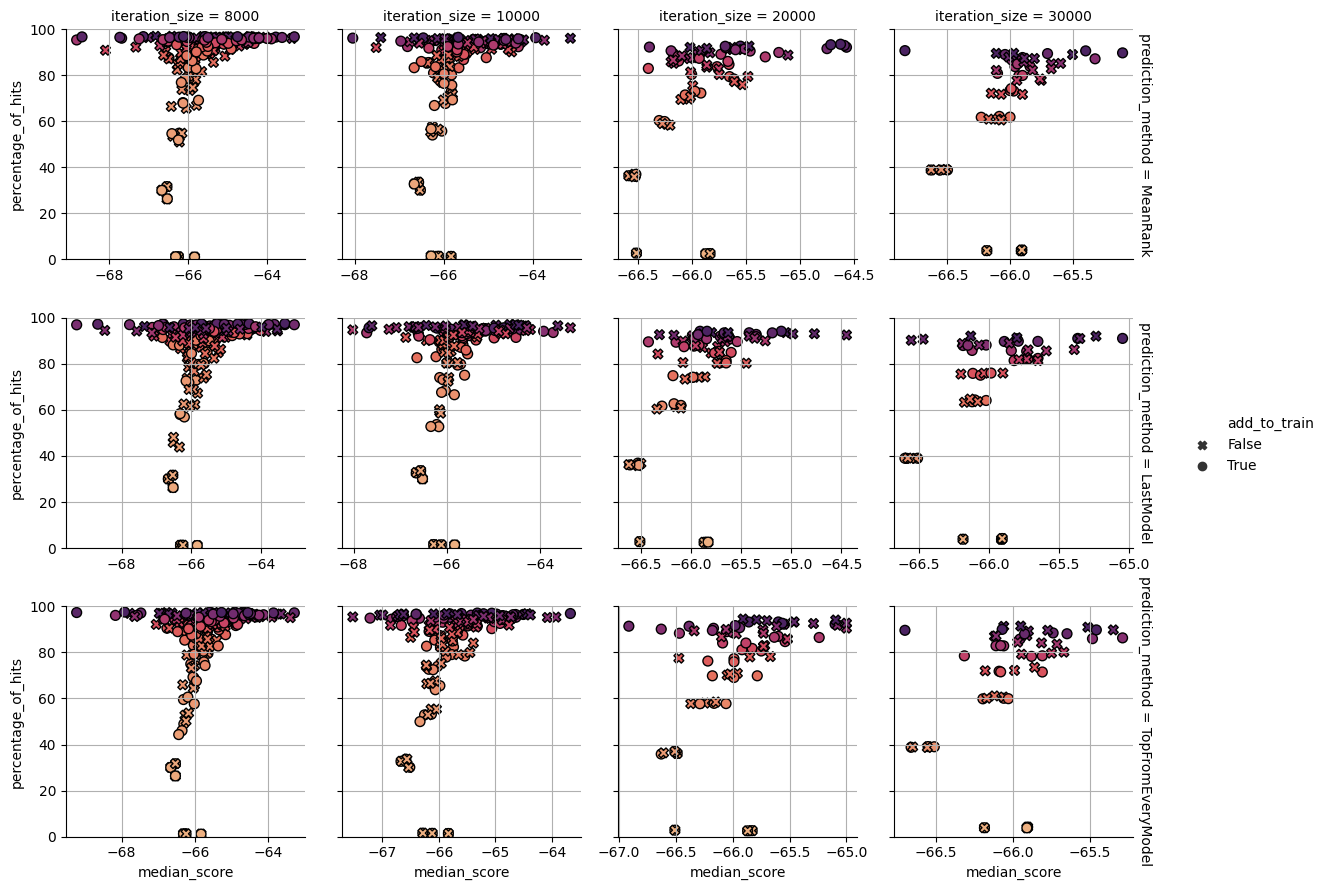

In [26]:
df = (raw_data
      .reset_index()
      .replace({
        'add':'True',
        'noadd':'False'
      })
      .pipe(add_iteration_size)
#       .query("add_to_train == 'False'")
      .query("type == 'regressor'")
#       .query("prediction_method == 'TopFromEveryModel'")
      .assign(model_and_proj = lambda df: df.proj + '_' + df.model)
#       .query('iteration == 1')
      .query("proj == 'AmpC'")
)

kwa = {
#     'x' : "log2_time_sec", 
    'x': 'median_score',
    'y': "percentage_of_hits", 
    'style': "add_to_train",
    'hue':'iteration',
    'edgecolor':'k',
    'linewidth':1,
    's':50,
#     'legend':False
}

grid = sns.FacetGrid(df, col = "iteration_size", row = "prediction_method", margin_titles=True, sharex=False)

(grid
 .map_dataframe(sns.scatterplot, **kwa, palette='flare')
#  .set(xscale = 'log')
)

for ax in grid.axes.flat:
    ax.grid()
    ax.set_ylim(0, 100)

included_labels = ['True','False','add_to_train']
grid.add_legend(legend_data = {k:v for k, v in grid._legend_data.items() if k in included_labels})
# plt.savefig('../figures/Figure_4.png')
plt.show()